In [2]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline

from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
#from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation

from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_7BroadVariants.csv'
Data_df = pd.read_csv(data_file)
Data_unVacc = Data_df[(Data_df.cat_VaccStatus!='Boosted')*(Data_df.cat_VaccStatus!='Second dose')*(Data_df.cat_VaccStatus!='First dose') ]
Data_unVacc_symp = Data_unVacc[Data_unVacc.cat_SympEver != 'No']
IDs_Symp = Data_unVacc_symp.ID.unique()
print(len(Data_unVacc_symp.ID.unique()))
Olddata_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_AppendNegatives.csv'
OldData_df = pd.read_csv(Olddata_file)
OldData_unVacc = OldData_df[(OldData_df.cat_VaccStatus!='Boosted')*(OldData_df.cat_VaccStatus!='Second dose')*(OldData_df.cat_VaccStatus!='First dose') ]


IDs_unVacc = Data_unVacc.ID.unique()
OldIDs_unVacc = OldData_unVacc.ID.unique()


DeltaCases = Data_unVacc[Data_unVacc.cat_Lineage7variants == 'Delta']

ID_Delta = DeltaCases.ID.unique()
#print(len(ID_Delta))
IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)

Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'

Popparameters_PK = pd.read_csv(Popparameters_U_file)

560


In [6]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [7]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [8]:
def PKPDParams(Popparameters, GetPopParams, GetParamsOmega, Emax, IC50, Hill, dose, PDOm):
    
    param_Order = ['ka', 'k12', 'k21', 'kcl', 'Vol', 'Emax', 'IC50', 'Hill']
    PKparams = GetPopParams(Popparameters, dose)
    PKparams_Val = PKparams['ka'], PKparams['kPL'], PKparams['kLP'], PKparams['kCl'],PKparams['Vol']
    PDparams = Emax, IC50, Hill
    PKPDparams = np.hstack((PKparams_Val, PDparams))
    
    PKOm = GetParamsOmega(Popparameters, dose)
    PKOm_Val = PKOm['ka'], PKOm['kPL'], PKOm['kLP'], PKOm['kCl'],PKOm['Vol']
    PKPDOm = np.hstack((PKOm_Val, PDOm))
    eta = np.random.normal(np.zeros(len(PKPDOm)), PKPDOm, len(PKPDOm))
    PKPDInd = PKPDparams*np.exp(eta)
    if PKPDInd[5]>1:
        PKPDInd[5]=1
    return dict(zip(param_Order, PKPDInd))

In [9]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

0    4.61
Name: Mean, dtype: float64

In [10]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol


In [11]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [12]:
    
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 30 #duration of simulation 30 days after symptom onset. 
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes[0])
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, MolMass)
        return t, y, dosetimes

In [13]:
def SimulateTreatment(VLPKPD, init, tzero, dt, tend, params, PKPDInd, dose, dosetimes, PotRed, MolMass):
    #Nirmatrelvir PD parameters
    E_max = PKPDInd['Emax']
    Hill_Coeff = PKPDInd['Hill']
    IC50 = PotRed*PKPDInd['IC50']

    #Nirmatrelvir PK Parameters for each individual
    ka = PKPDInd['ka']
    k12 = PKPDInd['k12']
    k21 = PKPDInd['k21']
    kcl = PKPDInd['kcl']
    Vol = PKPDInd['Vol']
    params_local = params.copy()
    params_local.extend([ka, k12, kcl, k21,Vol, MolMass, E_max, IC50, Hill_Coeff])
    args = tuple(params_local)
  
    if tzero==dosetimes[0]:
        for j in range(0,len(dosetimes)-1):
            init[5] = init[5] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            init = ytemp[-1,:].T
            if j==0:
                y= ytemp.copy()
                t= ttemp.copy()
            else:
                y = np.concatenate((y,ytemp), axis=0)
                t = np.concatenate((t,ttemp))
    else:       
        
        # simulate infection from tzero up to 1st dose
        t = np.arange(tzero, dosetimes[0],dt)
        # simulate using scipy integrate
        y = spi.odeint(VLPKPD, init, t, args = args)
   
        ytemp = y.copy()

        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init = ytemp[-1,:].T
            init[5] = init[5] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
        
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            t=np.concatenate((t,ttemp))
            y=np.concatenate((y,ytemp),axis=0)        
    #simulate until tend
    init = ytemp[-1,:].T
    init[5] = init[5] + dose 
    ttemp = np.arange(dosetimes[-1],tend,dt)
    ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
    t=np.concatenate((t,ttemp))
    y=np.concatenate((y,ytemp),axis=0)  
    return t, y

In [14]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V,10**2))
            v[v==2]=1
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == 1) & (t>Tmax))]

            while (len(PS_Duration) != 0 and PS_Duration[0]<5):
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V,10**2))
                v[v==2]=1
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == 1) & (t>Tmax))]
    
    return params, param_dict

In [19]:
dose = 0
Num= 400
Mean_drop_VL_TotPop_cntrl_runs = []
drop_VL_runs_cntrl = []
R2_run=[]

fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})

PotRed=1

for run in range(0,10):
    print(run)
    Mean_drop_VL_TotPop_cntrl=[]
    drop_VL=[]
    Cohort = Cohort_Prep(IDs_Symp, Num)
    TreatmntStrtDay = random.choices(range(1,4), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 3)
    #TreatmntStrtDay = [random.randint(1, 3) for i in range(0,len(Cohort))]
    VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                parameters_df, Popparameters_df, fixed_params, 
                                                param_order, param_dist, PKPDParams, 
                                                Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                IC50, Hill,PDOm, dose)
    for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):
        
        tzero_est = param_dict[idi]['tzero']
        tau_est = param_dict[idi]['tau']

        if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
            Lineage = 'Total'
            shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
            scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
        else:
            Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
            shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
            scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

        incub = np.random.gamma(shape, scale)

        VLInd[idi][-1] = VLInd[idi][-1]+(tzero_est-incub[0])
        param_dict[idi]['tzero']=incub[0]
        param_dict[idi]['tau']=VLInd[idi][-1]

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed, MolMass, dose, SetInit, VLPKPD, 
                                                     TreatmentLength = 5, TreatmentFrequency = 0.5)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**2))
        X[X==2]=1
        Tmax_index = np.argwhere(X==max(X))[0][0]
        Tmax = t[Tmax_index]

        PS_Duration = t[np.where((X == 1) & (t>Tmax))]
        while (len(PS_Duration) != 0 and PS_Duration[0]<5):
            VLInd[idi][-1] = tau_est
            param_dict[idi]['tzero']= tzero_est
            param_dict[idi]['tau'] = tau_est
            
            incub = np.random.gamma(shape, scale)

            VLInd[idi][-1] = VLInd[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=VLInd[idi][-1]

            t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed, MolMass, dose, SetInit, VLPKPD, 
                                                     TreatmentLength = 5, TreatmentFrequency = 0.5)
            T,R,E,I,V, Ag, A1, A2 = y.T
            X = np.log10(np.maximum(V,10**2))
            X[X==2]=1
            Tmax_index = np.argwhere(X==max(X))[0][0]
            Tmax = t[Tmax_index]
            PS_Duration = t[np.where((X == 1) & (t>Tmax))]

        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
        drop_VL.append(X[tstart:tend]-X[tstart])
        
    t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
    t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
    t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
    t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]

    Mean_drop_VL_TotPop_cntrl=np.mean(drop_VL, axis=0)
    r2 = r2_score([0,-1.5, -2.5, -3.8, -5], 
              [Mean_drop_VL_TotPop_cntrl[0], Mean_drop_VL_TotPop_cntrl[t3], Mean_drop_VL_TotPop_cntrl[t5], 
               Mean_drop_VL_TotPop_cntrl[t10],Mean_drop_VL_TotPop_cntrl[t14]])
    
    drop_VL_runs_cntrl.append(drop_VL)
    Mean_drop_VL_TotPop_cntrl_runs.append(Mean_drop_VL_TotPop_cntrl)
    R2_run.append(r2)


0
1
2
3
4
5
6
7
8
9


<Figure size 576x360 with 0 Axes>

In [20]:
np.round(R2_run,2)

array([0.92, 0.9 , 0.92, 0.93, 0.91, 0.92, 0.93, 0.93, 0.92, 0.93])

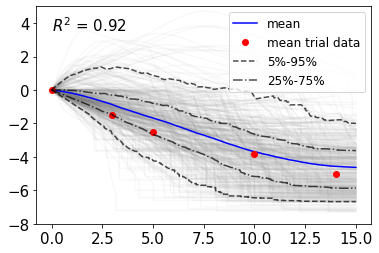

In [35]:
fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 15})
i= np.argwhere(np.round(R2_run,2) ==st.mode(np.round(R2_run,2))[0])[0][0]

for idi in range(0,400):
    plt.plot(np.linspace(0, 14.999, 15000),drop_VL_runs_cntrl[i][idi], color = 'grey', alpha = 0.05)
perc_5 = np.percentile(drop_VL_runs_cntrl[i], 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 14.999, 15000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 14.999, 100000))
perc_95 = np.percentile(drop_VL_runs_cntrl[i], 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 14.999, 15000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 14.999, 100000))
perc_25 = np.percentile(drop_VL_runs_cntrl[i], 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 14.999, 15000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 14.999, 100000))
perc_75 = np.percentile(drop_VL_runs_cntrl[i], 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 14.999, 15000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 14.999, 100000))
t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]



plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_cntrl_runs[i], color = 'b', label = 'mean')
plt.plot([0,3,5,10,14], [0,-1.5, -2.5, -3.8, -5],'o', color = 'red', label = 'mean trial data')
plt.plot(np.linspace(0, 14.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
plt.plot(np.linspace(0, 14.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
plt.plot(np.linspace(0, 14.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
plt.plot(np.linspace(0, 14.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)
plt.text(0,3.5,'$R^2$ = ' + str(round(R2_run[i],2)))
#plt.xlabel('Days since Treatment')
#plt.ylabel('log10(VL) Drop from baseline')
plt.ylim([-8, 5])
#plt.title('control arm')
plt.legend(fontsize="12")
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/controlEPIC.png')

In [222]:
n=0
fig = plt.figure(figsize = (20,15))
plt.rcParams.update({'font.size': 25})
prf = []
Num= 400
R2 = []
for run in np.arange(0,10):
    print(run)
# -------- Running the treatment arm ----------
    dose = 300
    PotRed = np.ones(Num)
    
    r2 = []
    Cohort = Cohort_Prep(IDs_Symp, Num)
    TreatmntStrtDay = random.choices(range(1,4), k=len(Cohort)) #treatment starting within 3 days of synptom onset (day 1 through 3)
    VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                parameters_df, Popparameters_df, fixed_params, 
                                                param_order, param_dist, PKPDParams, 
                                                Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                IC50, Hill,PDOm, dose)
    VLInd, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TreatmntStrtDay, VLInd, 
                                       PKPD_Params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    
    for PotRed in range(1,200, 4):
        
        print("  " + str(PotRed))
        V = []
        drop_VL = []
        Mean_drop_VL_TotPop = []
        
        for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
            
            
            t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed, MolMass, dose, SetInit, VLPKPD,
                                                         TreatmentLength = 5, TreatmentFrequency = 0.5)
            T,R,E,I,V, Ag, A1, A2 = y.T
            X = np.log10(np.maximum(V,10**2))
            X[X==2]=1
            tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
            tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
            drop_VL.append(X[tstart:tend]-X[tstart])

        Mean_drop_VL_TotPop=(np.mean(drop_VL, axis=0))
        t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
        t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
        t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
        t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]
        r2.append(r2_score([0,-1.85, -3.25, -4.25, -5.15], 
              [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], Mean_drop_VL_TotPop[t10],
              Mean_drop_VL_TotPop[t14]]))

    R2.append(r2)

0
  1
  5
  9
  13
  17
  21
  25
  29
  33
  37
  41
  45
  49
  53
  57
  61
  65
  69
  73
  77
  81
  85
  89
  93
  97
  101
  105
  109
  113
  117
  121
  125
  129
  133
  137
  141
  145
  149
  153
  157
  161
  165
  169
  173
  177
  181
  185
  189
  193
  197
1
  1
  5
  9
  13
  17
  21
  25
  29
  33
  37
  41
  45
  49
  53
  57
  61
  65
  69
  73
  77
  81
  85
  89
  93
  97
  101
  105
  109
  113
  117
  121
  125
  129
  133
  137
  141
  145
  149
  153
  157
  161
  165
  169
  173
  177
  181
  185
  189
  193
  197
2
  1
  5
  9
  13
  17
  21
  25
  29
  33
  37
  41
  45
  49
  53
  57
  61
  65
  69
  73
  77
  81
  85
  89
  93
  97
  101
  105
  109
  113
  117
  121
  125
  129
  133
  137
  141
  145
  149
  153
  157
  161
  165
  169
  173
  177
  181
  185
  189
  193
  197
3
  1
  5
  9
  13
  17
  21
  25
  29
  33
  37
  41
  45
  49
  53
  57
  61
  65
  69
  73
  77
  81
  85
  89
  93
  97
  101
  105
  109
  113
  117
  121
  125
  129
  133


<Figure size 1440x1080 with 0 Axes>

In [211]:
pickle.dump(R2 , open('FigureData/prf_R2.pickle', 'wb'))


In [36]:
R2 = pickle.load(open('FigureData/prf_R2.pickle', 'rb'))

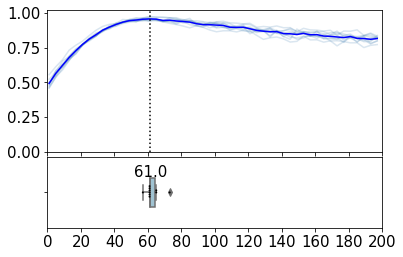

In [37]:
fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 15})
gs = fig.add_gridspec(2, hspace=0.05, height_ratios= [2, 1])
axs = gs.subplots(sharex=True)
prf=[]
for run in np.arange(0,10):
    axs[0].plot(range(1,200,4), R2[run], color= 'steelblue', alpha = 0.2)
    
    prf_index= np.argwhere(R2[run]==max(R2[run]))
    prf.append(range(1,200,4)[prf_index[0][0]]) 
R2_Ave=np.mean(R2, axis=0)
axs[0].plot(range(1,200,4), R2_Ave, color= 'b', alpha = 1, label= 'All')
axs[0].vlines(x = np.median(prf) , ymin = 0.0, ymax = 1.5, color = 'k', linestyle = 'dotted')
axs[0].set_ylim([0.0, 1.02])
axs[0].set_yticks([0.0, 0.25, 0.5, 0.75, 1.])
axs[0].set_xlim([0,200])
#axs[0].set_ylabel('$R^2$ of the treatment arm \n fit to data')
sns.swarmplot(x=prf, color = 'k', size = 2, ax = axs[1])
sns.boxplot(x=prf, color = 'skyblue', saturation=0.5, width=0.4, ax = axs[1])
axs[1].text(np.median(prf) + np.median(prf)*0.01,axs[1].get_yticks()-0.22,np.median(prf), 
            horizontalalignment='center',size='medium',color='k')
axs[1].set_xticks(range(0,220,20))
#axs[1].set_xlabel('prf')
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/prf_R2_EPIC.png')

In [38]:
prf

[73, 61, 61, 61, 61, 65, 57, 61, 61, 65]

0
1
2
3
4
5
6
7
8
9


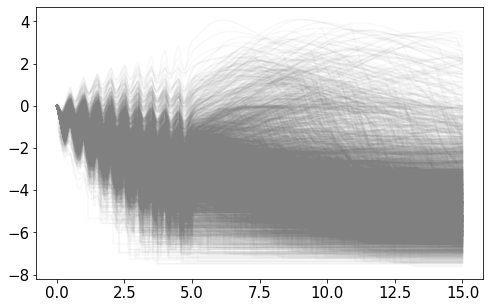

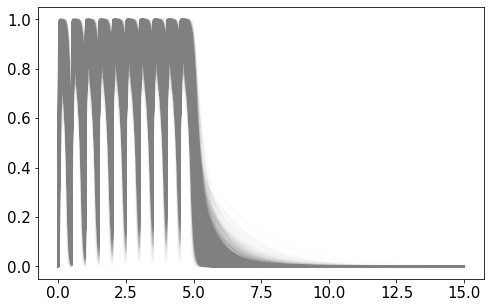

In [261]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol
dose = 300
Num= 400
n=0
fig1 = plt.figure(1, figsize = (8,5))
ax1 = fig1.add_subplot(1,1,1)
fig2 = plt.figure(2,figsize = (8,5))
ax2 = fig2.add_subplot(1,1,1)
plt.rcParams.update({'font.size': 17})
Mean_drop_VL_TotPop_runs = []
drop_VL_runs = []
R2_trtmnt_runs=[]


for run in range(0,10):
    print(run)
    Mean_drop_VL_TotPop = []
    #Mean_drop_VL_five_VirCohort = []
    Std_drop_VL_TotPop= []
    #Std_drop_VL_five_VirCohort = []
    drop_VL = []
    epsN=[]
    E = []
    Cohort = Cohort_Prep(IDs_Symp, Num)
    PotRed=np.random.normal(np.mean(prf), np.std(prf), Num)
    TreatmntStrtDay = random.choices(range(1,4), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 3)
    VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                parameters_df, Popparameters_df, fixed_params, 
                                                param_order, param_dist, PKPDParams, 
                                                Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                IC50, Hill,PDOm, dose)
    for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):
        
        if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
            Lineage = 'Total'
            shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
            scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
        else:
            Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
            shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
            scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            
        incub = np.random.gamma(shape, scale)

        VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
        param_dict[idi]['tzero']=incub[0]
        param_dict[idi]['tau']=VLInd[idi][-1]
        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**2))
        X[X==2]=1

        Tmax_index = np.argwhere(X==max(X))[0][0]
        Tmax = t[Tmax_index]

        PS_Duration = t[np.where((X == 1) & (t>Tmax))]
        while (len(PS_Duration) != 0 and PS_Duration[0]<5):
            incub = np.random.gamma(shape, scale)

            VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=VLInd[idi][-1]

            t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed[idi], MolMass, 0, SetInit, VLPKPD, 
                                                     TreatmentLength = 5, TreatmentFrequency = 0.5)
            T,R,E,I,V, Ag, A1, A2 = y.T
            X = np.log10(np.maximum(V,10**2))
            X[X==2]=1
            Tmax_index = np.argwhere(X==max(X))[0][0]
            Tmax = t[Tmax_index]
            PS_Duration = t[np.where((X == 1) & (t>Tmax))]

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed[idi], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**2))
        X[X==2]=1
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
        drop_VL.append(X[tstart:tend]-X[tstart])
        ax1.plot(t[tstart:tend]-t[tstart],drop_VL[idi], color = 'grey', alpha = 0.05)

        conc = A1*10**6/PKPD_Params[idi]['Vol']/MolMass # # convert to from nanogram/mL to micromolar
        epsN.append(np.divide(np.multiply(PKPD_Params[idi]['Emax'],np.power(conc[tstart:tend],PKPD_Params[idi]['Hill'])),
                         (np.power(PotRed[idi]*PKPD_Params[idi]['IC50'], PKPD_Params[idi]['Hill'])+
                          np.power(conc[tstart:tend],PKPD_Params[idi]['Hill']))))
        ax2.plot(t[tstart:tend]-t[tstart],epsN[idi], color = 'grey', alpha = 0.02)

    Mean_drop_VL_TotPop=np.mean(drop_VL, axis=0)
    r2 = r2_score([0,-1.85, -3.25, -4.25, -5.15], 
              [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], Mean_drop_VL_TotPop[t10],
              Mean_drop_VL_TotPop[t14]])
    Eff = np.mean(epsN, axis=0)
    Mean_drop_VL_TotPop_runs.append(Mean_drop_VL_TotPop)
    drop_VL_runs.append(drop_VL)
    R2_trtmnt_runs.append(r2)
    

#fig1.savefig('TreatmentArm_RandomCohort.svg')
#fig2.savefig('DrugEfficacy_RandomCohort.svg')

In [262]:
np.round(R2_trtmnt_runs,2)

array([0.94, 0.96, 0.94, 0.96, 0.95, 0.97, 0.96, 0.96, 0.95, 0.96])

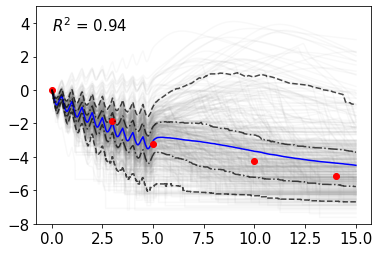

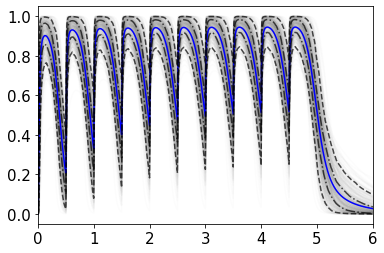

In [264]:
fig1 = plt.figure(1, figsize = (6,4))
ax1 = fig1.add_subplot(1,1,1)
plt.rcParams.update({'font.size': 15})
fig2 = plt.figure(2,figsize = (6,4))
ax2 = fig2.add_subplot(1,1,1)
plt.rcParams.update({'font.size': 15})
i= np.argwhere(np.round(R2_trtmnt_runs,2) ==st.mode(np.round(R2_trtmnt_runs,2)))[0][0]

for idi in range(0,400):
    ax1.plot(np.linspace(0, 14.999, 15000),drop_VL_runs[i][idi], color = 'grey', alpha = 0.05)
    ax2.plot(np.linspace(0, 14.999, 15000),epsN[idi], color = 'grey', alpha = 0.02)
perc_5 = np.percentile(drop_VL_runs[i], 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 14.999, 15000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 14.999, 100000))
perc_95 = np.percentile(drop_VL_runs[i], 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 14.999, 15000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 14.999, 100000))
perc_25 = np.percentile(drop_VL_runs[i], 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 14.999, 15000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 14.999, 100000))
perc_75 = np.percentile(drop_VL_runs[i], 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 14.999, 15000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 14.999, 100000))

perc_5_E = np.percentile(epsN, 5, axis = 0)
spl_5_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_5_E)
perc_5_smooth_E = spl_5_E(np.linspace(0, 14.999, 100000))
perc_95_E = np.percentile(epsN, 95, axis = 0)
spl_95_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_95_E)
perc_95_smooth_E = spl_95_E(np.linspace(0, 14.999, 100000))
perc_25_E = np.percentile(epsN, 25, axis = 0)
spl_25_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_25_E)
perc_25_smooth_E = spl_25_E(np.linspace(0, 14.999, 100000))
perc_75_E = np.percentile(epsN, 75, axis = 0)
spl_75_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_75_E)
perc_75_smooth_E = spl_75_E(np.linspace(0, 14.999, 100000))
t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]

Mean_drop_TotPop_Trtmnt_61 = Mean_drop_VL_TotPop_runs[i].copy()
ax1.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_runs[i], color = 'b')
#ax1.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop, color = 'lime')
ax1.plot([0,3,5,10,14], [0,-1.85, -3.25, -4.25, -5.15],'o', color = 'red')
ax1.plot(np.linspace(0, 14.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
ax1.plot(np.linspace(0, 14.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
ax1.plot(np.linspace(0, 14.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
ax1.plot(np.linspace(0, 14.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)

ax1.text(0,3.5,'$R^2$ = ' + str(np.round(R2_trtmnt_runs[i],2)))
#ax1.set_xlabel('Days since Treatment')
#ax1.set_ylabel('log10(VL) Drop from baseline')
ax1.set_ylim([-8, 5])
#ax1.set_title('treatment arm')

E_61 = Eff.copy()
ax2.plot(np.linspace(0, 14.999, 15000), E_61, color = 'b')

ax2.plot(np.linspace(0, 14.999, 100000), perc_5_smooth_E, '--', color = 'k', alpha = 0.7,label = '5%-95%')
ax2.plot(np.linspace(0, 14.999, 100000), perc_95_smooth_E, '--', color = 'k',alpha = 0.7)
ax2.plot(np.linspace(0, 14.999, 100000), perc_25_smooth_E, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
ax2.plot(np.linspace(0, 14.999, 100000), perc_75_smooth_E, '-.', color = 'k',alpha = 0.7)
#ax2.set_xlabel('Days since Treatment')
#ax2.set_ylabel('Drug Efficacy')
ax2.set_xlim([0, 6])

plt.show()

In [260]:
len(E_61)

36906

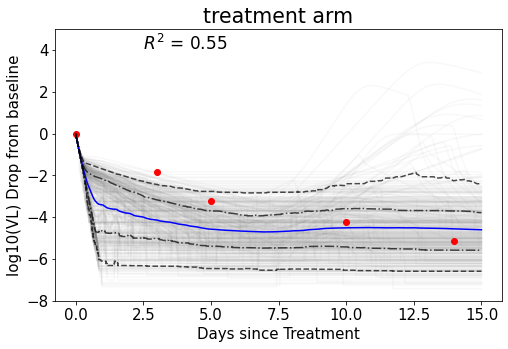

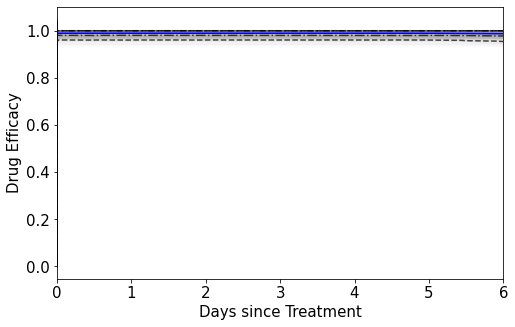

In [111]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol
dose = 300
Num= 400
n=0
Mean_drop_VL_TotPop = []
#Mean_drop_VL_five_VirCohort = []
Std_drop_VL_TotPop= []
#Std_drop_VL_five_VirCohort = []
drop_VL = []
epsN=[]
E = []
Cohort = Cohort_Prep(IDs_unVacc, Num)
PotRed=np.ones(Num)
fig1 = plt.figure(1, figsize = (8,5))
ax1 = fig1.add_subplot(1,1,1)
fig2 = plt.figure(2,figsize = (8,5))
ax2 = fig2.add_subplot(1,1,1)
plt.rcParams.update({'font.size': 17})
TreatmntStrtDay = random.choices(range(1,4), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 3)
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)
for idi, ID, TrtmntStrtDay in zip(range(0,Num), Cohort, TreatmntStrtDay):
    
    if Data_unVacc[Data_unVacc.ID == ID].cat_LineageBroad.unique()[0]=='Other':
        Lineage = random.choice(['Historical', 'Alpha', 'Beta_Gamma'])

        shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
        scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
    
    elif Data_unVacc[Data_unVacc.ID == ID].cat_LineageBroad.unique()[0]=='None':
        Lineage = 'Total'
        shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
        scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
    else:
        Lineage = Data_unVacc[Data_unVacc.ID==ID].cat_LineageBroad.unique()[0]
        shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
        scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

    incub = np.random.gamma(shape, scale)

    VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
    param_dict[idi]['tzero']=incub[0]
    param_dict[idi]['tau']=VLInd[idi][-1]
    t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                                         TreatmentLength = 5, TreatmentFrequency = 0.5)
    T,R,E,I,V, Ag, A1, A2 = y.T
    X = np.log10(np.maximum(V,10**2))
    X[X==2]=1
            
    Tmax_index = np.argwhere(X==max(X))[0][0]
    Tmax = t[Tmax_index]

    PS_Duration = t[np.where((X == 1) & (t>Tmax))]
    while (PS_Duration != [] and PS_Duration[0]<5):
        incub = np.random.gamma(shape, scale)

        VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
        param_dict[idi]['tzero']=incub[0]
        param_dict[idi]['tau']=VLInd[idi][-1]

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                     PotRed[idi], MolMass, 0, SetInit, VLPKPD, 
                                                 TreatmentLength = 5, TreatmentFrequency = 0.5)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**2))
        X[X==2]=1
        Tmax_index = np.argwhere(X==max(X))[0][0]
        Tmax = t[Tmax_index]
        PS_Duration = t[np.where((X == 1) & (t>Tmax))]
            
    t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed[idi], MolMass, dose, SetInit, VLPKPD,
                                                         TreatmentLength = 5, TreatmentFrequency = 0.5)
    T,R,E,I,V, Ag, A1, A2 = y.T
    X = np.log10(np.maximum(V,10**2))
    X[X==2]=1
    tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
    tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
    drop_VL.append(X[tstart:tend]-X[tstart])
    ax1.plot(t[tstart:tend]-t[tstart],drop_VL[idi], color = 'grey', alpha = 0.05)
    
    conc = A1*10**6/PKPD_Params[idi]['Vol']/MolMass # # convert to from nanogram/mL to micromolar
    epsN.append(np.divide(np.multiply(PKPD_Params[idi]['Emax'],np.power(conc[tstart:tend],PKPD_Params[idi]['Hill'])),
                     (np.power(PotRed[idi]*PKPD_Params[idi]['IC50'], PKPD_Params[idi]['Hill'])+
                      np.power(conc[tstart:tend],PKPD_Params[idi]['Hill']))))
    ax2.plot(t[tstart:tend]-t[tstart],epsN[idi], color = 'grey', alpha = 0.02)
        
Mean_drop_VL_TotPop=np.mean(drop_VL, axis=0)
Median_drop_VL_TotPop=np.median(drop_VL, axis=0)
E = np.mean(epsN, axis=0)

perc_5 = np.percentile(drop_VL, 5, axis = 0)
spl_5 = CubicSpline(np.linspace(0, 14.999, 15000), perc_5)
perc_5_smooth = spl_5(np.linspace(0, 14.999, 100000))
perc_95 = np.percentile(drop_VL, 95, axis = 0)
spl_95 = CubicSpline(np.linspace(0, 14.999, 15000), perc_95)
perc_95_smooth = spl_95(np.linspace(0, 14.999, 100000))
perc_25 = np.percentile(drop_VL, 25, axis = 0)
spl_25 = CubicSpline(np.linspace(0, 14.999, 15000), perc_25)
perc_25_smooth = spl_25(np.linspace(0, 14.999, 100000))
perc_75 = np.percentile(drop_VL, 75, axis = 0)
spl_75 = CubicSpline(np.linspace(0, 14.999, 15000), perc_75)
perc_75_smooth = spl_75(np.linspace(0, 14.999, 100000))

perc_5_E = np.percentile(epsN, 5, axis = 0)
spl_5_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_5_E)
perc_5_smooth_E = spl_5_E(np.linspace(0, 14.999, 100000))
perc_95_E = np.percentile(epsN, 95, axis = 0)
spl_95_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_95_E)
perc_95_smooth_E = spl_95_E(np.linspace(0, 14.999, 100000))
perc_25_E = np.percentile(epsN, 25, axis = 0)
spl_25_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_25_E)
perc_25_smooth_E = spl_25_E(np.linspace(0, 14.999, 100000))
perc_75_E = np.percentile(epsN, 75, axis = 0)
spl_75_E = CubicSpline(np.linspace(0, 14.999, 15000), perc_75_E)
perc_75_smooth_E = spl_75_E(np.linspace(0, 14.999, 100000))
t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]
r2 = r2_score([0,-1.85, -3.25, -4.25, -5.15], 
              [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], Mean_drop_VL_TotPop[t10],
              Mean_drop_VL_TotPop[t14]])
r2= np.round(r2,4)
Mean_drop_TotPop_Trtmnt_1 = Mean_drop_VL_TotPop.copy()
ax1.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop, color = 'b')
#ax1.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop, color = 'lime')
ax1.plot([0,3,5,10,14], [0,-1.85, -3.25, -4.25, -5.15],'o', color = 'red')
ax1.plot(np.linspace(0, 14.999, 100000), perc_5_smooth, '--', color = 'k', alpha = 0.7,label = '5%-95%')
ax1.plot(np.linspace(0, 14.999, 100000), perc_95_smooth, '--', color = 'k',alpha = 0.7)
ax1.plot(np.linspace(0, 14.999, 100000), perc_25_smooth, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
ax1.plot(np.linspace(0, 14.999, 100000), perc_75_smooth, '-.', color = 'k',alpha = 0.7)

ax1.text(2.5,4,'$R^2$ = ' + str(np.round(r2,2)))
ax1.set_xlabel('Days since Treatment')
ax1.set_ylabel('log10(VL) Drop from baseline')
ax1.set_ylim([-8, 5])
ax1.set_title('treatment arm')

E_1 = E.copy()
ax2.plot(np.linspace(0, 14.999, 15000), E, color = 'b')

ax2.plot(np.linspace(0, 14.999, 100000), perc_5_smooth_E, '--', color = 'k', alpha = 0.7,label = '5%-95%')
ax2.plot(np.linspace(0, 14.999, 100000), perc_95_smooth_E, '--', color = 'k',alpha = 0.7)
ax2.plot(np.linspace(0, 14.999, 100000), perc_25_smooth_E, '-.', color = 'k', alpha = 0.7, label = '25%-75%')
ax2.plot(np.linspace(0, 14.999, 100000), perc_75_smooth_E, '-.', color = 'k',alpha = 0.7)
ax2.set_xlabel('Days since Treatment')
ax2.set_ylabel('Drug Efficacy')
ax2.set_xlim([0, 6])

plt.show()
#fig1.savefig('TreatmentArm_RandomCohort.svg')
#fig2.savefig('DrugEfficacy_RandomCohort.svg')

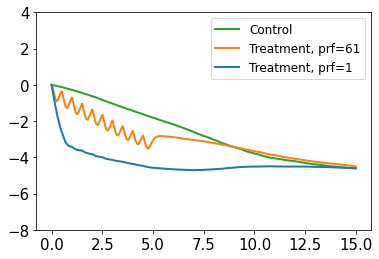

In [269]:
plt.figure(1, figsize = (6,4))
plt.rcParams.update({'font.size': 15})
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_cntrl, color = 'tab:green',label = 'Control', linewidth = 2)
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_TotPop_Trtmnt_61, color = 'tab:orange', 
         label = 'Treatment, prf=61', linewidth = 2)
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_TotPop_Trtmnt_1, color = 'tab:blue',
         label = 'Treatment, prf=1', linewidth = 2)
plt.ylim([-8,4])
#plt.yticks([-5,-4,-3,-2,-1,0])
#plt.xlabel('Days since Treatment')
#plt.ylabel('log10(VL) Drop from baseline')
plt.legend(fontsize="12")
#plt.savefig('TreatmentArm_RandomCohort_prfComp.svg')

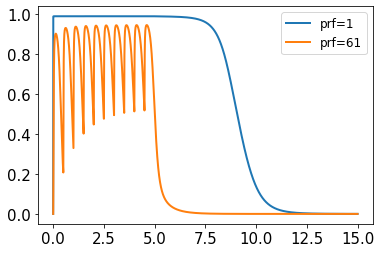

In [271]:
plt.figure(1, figsize = (6,4))
plt.rcParams.update({'font.size': 15})
plt.plot(np.linspace(0, 14.999, 15000), E_1, color = 'tab:blue',
         label = 'prf=1', linewidth = 2)

plt.plot(np.linspace(0, 14.999, 15000), E_61, color = 'tab:orange', 
         label = 'prf=61', linewidth = 2)
plt.legend(fontsize="12")
#plt.xlabel('Days since Treatment')
#plt.ylabel('mean drug efficacy')

#plt.savefig('TreatmentArm_RandomCohort_prfComp.svg')